In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import glob
import os

In [3]:
folder_cutouts = 'cutouts_ceers/'
df_ceers = pd.read_csv(glob.glob(folder_cutouts + '*.csv')[0])
df_ceers.shape

(906, 56)

In [4]:
s = df_ceers['z_mean'].between(0.3, 0.75)
df_ceers[s]

,ID,FIELD,RA,DEC,z_mean,AB115,AB150,AB200,AB277,AB356,...,FLUX_277,FLUX_356,FLUX_410,FLUX_444,FLUX_606,FLUX_814,FLUX_105,FLUX_125,FLUX_140,FLUX_160
1,122,1,214.929367,52.965049,0.306588,18.989539,18.727832,18.562784,18.775788,19.310682,...,112120.416081,68505.776823,70760.557158,66568.534913,34881.988658,60641.555603,0.0,95393.474204,1.029392e+05,112377.643110
2,168,1,214.918392,52.957740,0.373215,22.379111,22.243714,22.164716,22.295961,22.831174,...,4381.426870,2676.273572,2359.392676,2444.180791,2244.109736,3211.861237,0.0,3931.430039,4.339430e+03,4310.543300
3,223,1,214.942718,52.973940,0.571436,20.196199,19.934903,19.699136,19.473676,19.836993,...,58956.234459,42189.329321,33261.853249,32204.456764,9081.797710,18975.322881,0.0,29715.224480,3.366302e+04,37909.039076
5,915,1,214.942447,52.971891,0.379584,21.987143,21.847660,21.728829,21.788047,22.336756,...,6994.895846,4219.855601,3959.805337,3856.547927,4605.775656,4980.518148,0.0,5890.517371,6.005504e+03,6119.510660
7,1558,1,215.005530,53.011909,0.401773,21.675162,21.512633,21.382449,21.517443,21.929334,...,8974.755069,6141.386677,5449.023519,5492.899955,3703.113603,5636.852648,0.0,7674.608519,-7.738011e-04,8488.305369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,101089,10,214.866472,52.766706,0.466082,23.441369,23.305123,23.214276,23.217518,23.721987,...,1874.963907,1178.162061,1037.206903,1008.682195,718.792172,1193.350260,0.0,1532.776749,-1.179402e-33,1650.375777
902,101298,10,214.892175,52.783670,0.620438,22.249950,22.131283,21.991648,21.791062,22.126381,...,6975.495597,5122.095987,4146.682004,4049.227752,2147.074139,3469.897408,0.0,4146.235258,2.778393e-12,4684.408075
903,101365,10,214.889586,52.781789,0.569069,23.411952,23.238060,23.167866,23.076813,23.457918,...,2134.394223,1502.562946,1318.259948,1255.275279,572.698652,1093.063304,0.0,1515.644024,-5.278027e-13,1848.620195
904,101373,10,214.880378,52.774835,0.384050,23.309243,23.234000,23.184913,23.350707,23.829497,...,1658.506277,1067.090018,911.956757,851.134653,1197.699555,1478.800049,0.0,1655.334118,1.696844e+03,1704.996791


In [5]:
# settings
field = 5
N_foregrounds_per_galaxy = 10
folder_out = 'cutouts_testing/original_flux/'
folder_foregrounds = 'cutouts_raw/'


def get_data_dict(h5file):
    with h5py.File(h5file,'r') as f:
        data_dict = {}
        for key in f.keys():
            data_dict[key] = f[key][:]
    return data_dict

# create synthetic data
h5_file = glob.glob(folder_cutouts + f'Field{field}_*.h5')[0]
s_field = df_ceers['FIELD'].eq(field)
galaxy_IDs = df_ceers[s & s_field]['ID'].values
with h5py.File(h5_file, 'r') as f:
    for g_id in galaxy_IDs:
        # get the 'background' galaxy
        id_galaxy = str(g_id)
        filters = list(f[id_galaxy].keys())
        dict_galaxy = f[id_galaxy]
        
        # get the foreground stellar field
        N_foregrounds = 0
        while N_foregrounds < N_foregrounds_per_galaxy:
            try:
                f_id = np.random.choice(range(500))
                id_foreground = str(f_id).zfill(3)
                file_foreground = folder_foregrounds  + f'{id_foreground}.h5'
                dict_foreground = get_data_dict(file_foreground)
                
                # stack the data and save
                file_out = folder_out + f'{id_galaxy}_{id_foreground}.h5'
                with h5py.File(file_out, 'w') as f_out:
                    for filt in filters:
                        data_galaxy = dict_galaxy[filt][:]
                        data_foreground = dict_foreground[filt]
                        data_combined = data_galaxy + data_foreground
                        f_out.create_dataset(filt, data=data_combined)
                N_foregrounds += 1
            except Exception as e:
                continue
            

[sphot WARNING] (06/18/24 14:40:19)-- PSFs_dict is not provided. (data.load_h5data)


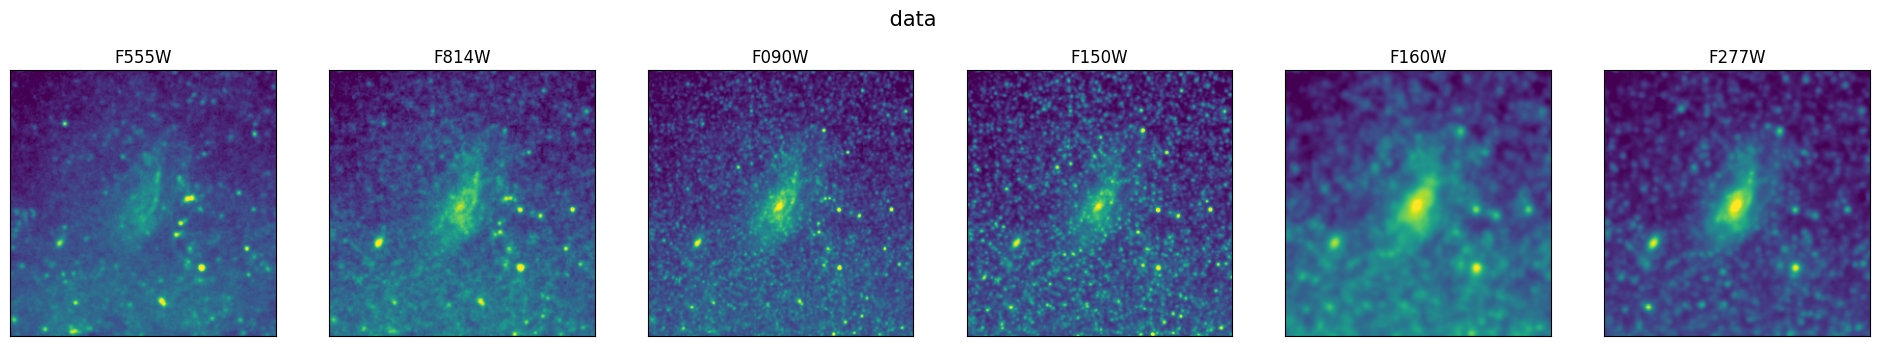

In [37]:
from sphot.data import load_h5data
filters = ['F555W','F814W','F090W','F150W','F160W','F277W']
test_files = glob.glob('cutouts_testing/original_flux/*.h5')
galaxy = load_h5data(test_files[100],filters = filters)
galaxy.plot()